## FWA Questionable Claim Identification: Unsupervised Approach


#### References:
- Brocket, et. al.: [*Fraud Classification Using Pricipal Component Analysis of RIDITs*, The Journal of Risk and Insurance, 2002 Vol. 69, No. 3, 341-371.](https://www.fox.temple.edu/cms/wp-content/uploads/2012/06/Richard-Derrig_11.pdf).      
<br>      
- Frees, et. al.: *Predictive Modeling Applications in Actuarial Science Volume II; Case Studies in Insurance*: Cambridge University Press 2016, pp. 180-189.      
<br>
- Phua, et. al. [*A Comprehensive Survey of Data Mining-based Fraud Detection Research*](https://arxiv.org/ftp/arxiv/papers/1009/1009.6119.pdf).   
<br>




## Introduction

PRIDIT, an acronym for *Principal Components of RIDITS*, are a percentile-based statistic. The RIDIT 
transformation is generally applied to variables whose values can be considered in some sense to be 
ordered. These might be answers to a survey (i.e., disagree, neutral, agree, etc.), but the 
variables might also be binary or categorical variables believed to be related to suspicion of a 
questionable claim and the other to a likely legitimate claim.   

PRIDIT analysis is comprised of two steps: The first involves calculating a RIDIT score for 
each quality measure. The second step applies a Principal Components transformation to the RIDIT 
scores. The primary assumption within the context of FWA data is that the first principal component 
is the component representing questionable activity, and any remaining variation in the data is due 
to other factors not directly related to questionable activity. Each component is mathematically 
unrelated or orthogonal, but the first component assumption is based on a combination of 
the selected feratures and expert judgment.         

The first principal component is the basis for the PRIDIT scores. PRIDIT applies the factor weights to the 
normalized RIDIT scores such that each claim receives a final weighted average RIDIT score, or *PRIDIT
score*. By default, PRIDIT scores data on a [-1, 1] scale. The final results have been rescaled to the 
[0, 100] range for ease of interpretation.

The meaning of PRIDIT will change based on the type of data used to calculate the scores. The first 
principle component generated from PCA is the basis of the PRIDIT algorithm, which combines the 
variation in all features input into the system. We assume that variable categories are ordered 
in decreasing likelihood of fraud suspicion such that higher categorical responses are associated 
with a lower propensity of fraud. There is no dependent or "left hand side" variable to assess the 
results of PRIDIT. Instead:


> ***The actual result of PRIDIT is simply the strongest determinant of 
> variation in the data — what we choose to put into the model determines what we get out of it.
> The final PRIDIT score is a proxy measure of the underlying latent characteristic of overall 
> questionable activity.***



The FWA unsupervised approach has been designed with scalability and flexibility in mind: Additional 
features can be included/excluded on the fly without modifying the underlying implementation. In terms 
of scalability, since there is no explicit matrix inversion, runtime scales linearly with respect to 
the number of records in the target dataset, as opposed to $O(n^{3})$ for more conventional routines 
that rely on explicit feature matrix inversion.



<br>
<br>

## PRIDIT Score Formulation

The scoring logic is described in detail in Brocket (2002) Appendix A., but an high-level overview is provided 
here. Symbolic references are are preserved in the code where possible.

To begin, we create a 2-dimensional array consisting of RIDIT scores. The RIDIT transformation is typically 
applied to variables with ordered levels, and is considered distribution free. If a variable does not have a 
pre-specified ordering (such as {"Male", "Female"}, {"Red", "Green", "Blue"}, etc.),  we can perform a 
one-hot encoding, representing a variable with $k$ levels into $k-1$ indicator columns.          
The RIDIT score represents a probability transformation based on the empirical distribution of the data.  
For categorical variable $X$ with levels having known ordinal relationship, the proportion of records for each 
level is computed, along with the cumulative proportion across all levels from low to high. Continuous features 
are binned using no more than ten categories. After the cumulative proportions have been computed for all 
variates, RIDIT scores are computed for each $X_{i}$ using one of two similar formulations:    
<br>    

$$
\begin{align*} 
RIDIT(X_{i}) &= P(X \lt X_{i-1}) - P(X \gt X_{i}) \\
             &= P(X \lt X_{i}) + \frac{1}{2}P(X=X_{i})
\end{align*} 
$$

The second formulation represents variable levels to a $[0, 1]$ scale, while the Brocket (2002) formulation 
ranges from $[-1, +1]$. 



<br>

- $X$ = Matrix of RIDIT scores  
<br>  
- $B$ = Normalized RIDIT matrix   
<br>  
- $\lambda$ = First eigenvalue resulting from PCA   
<br>  
- $\bar{x}$ = First eigenvector resulting from PCA    
<br>  
- $w$ = PRIDIT weights, given by $\sqrt{\lambda}\bar{x}$       
<br>  

$B$ is given by

$$
B = \frac{X^{T}X}{\sqrt{diag(X^{T}X)}},
$$
<br>   
which represents the normalized RIDIT matrix. Once we have $B$, PRIDIT scores are computed as:


$$
\text{PRIDIT} = \frac{B w}{\lambda}.
$$
<br>
<br>


In [1]:
"""
Configuration details.

REVIEW_THRESHOLD: Either a float or integer. If given as integer `n` > 0, 
                  the n claims with the highest PRIDIT scores will
                  be flagged for priority review. If n is a float `f` 
                  between [0, 1], then int(`f` * nrow ) records will be 
                  flagged for priority review. 
                  
DATA_PATH       : Absolute path to TRAINING.csv. This file should be present
                  in the `Datasets` directory of the FWA repository. 
                  
EXPORT_PATH     : Path to which PRIDIT transformation summary output will be 
                  written.    
"""
REVIEW_THRESHOLD = .005
DATA_PATH        = "C:\\Users\\cac9159\\Repos\\LTC\\FWA\\Datasets\\TRAINING.csv"
EXPORT_PATH      = "C:\\Users\\cac9159\\Repos\\LTC\\FWA\\Output"


In [2]:
"""
Read in FWA training dataset. Update PATH variable to point
to local working copy's `TRAINING.csv`.
"""
import datetime
import os
import os.path
import re
import sys
import time
import uuid
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

pd.options.mode.chained_assignment = None # "warn"
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 500)
np.set_printoptions(
    edgeitems=5, linewidth=200, suppress=True, nanstr='NaN',
    infstr='Inf', precision=5
    )

dfinit = pd.read_csv(DATA_PATH, sep=",", error_bad_lines=False)

keycols   = ["CLAIM_NUMBER", "POLICY_NUMBER", "RESIDENT_STATE",] #"FRAUD_INDICATOR"]
cont_vars = ["PAID_AMOUNT", "DLR_AMT"]
cat_vars  = ["ATTAINED_AGE_BANDED", "BENEFIT_PERIOD", "BENEFIT_TRIGGER_OPTIONS", "COLI", 
             "DAILY_BENEFIT_INFL_BANDED", "DUAL_WAIVER", "INDEMNITY_VS_EXPENSE_INCURRED", 
             "LINKED_POLICY_INDICATOR", "MAX_REPEATED_CALLS", "PREMIUM_PAYMENT_MODE", 
             "PREMIUM_WAIVED", "RESTORATION_OF_BENEFITS", "SITUS_CURRENT", 
             "TAX_QUALIFIED_STATUS", "UNDERWRITING_CLASS", "ELIM_PERIOD_BANDED",]

df = dfinit[keycols + cont_vars + cat_vars]
nrows, ncols = df.shape[0], df.shape[1]
df.head()


,CLAIM_NUMBER,POLICY_NUMBER,RESIDENT_STATE,PAID_AMOUNT,DLR_AMT,ATTAINED_AGE_BANDED,BENEFIT_PERIOD,BENEFIT_TRIGGER_OPTIONS,COLI,DAILY_BENEFIT_INFL_BANDED,DUAL_WAIVER,INDEMNITY_VS_EXPENSE_INCURRED,LINKED_POLICY_INDICATOR,MAX_REPEATED_CALLS,PREMIUM_PAYMENT_MODE,PREMIUM_WAIVED,RESTORATION_OF_BENEFITS,SITUS_CURRENT,TAX_QUALIFIED_STATUS,UNDERWRITING_CLASS,ELIM_PERIOD_BANDED
0,4301079034,76186268,CA,0.0,13659.69,>=90,3 Years,Medical Necessity,N,<$100,N,Indemnity,0,0,Annual,N,Y,NH,NTQ,Standard,>0 & <=30
1,4301068986,76201941,AZ,23340.0,21862.42,>=90,3 Years,Medical Necessity,N,<$100,N,Indemnity,0,0,Annual,N,Y,NH,NTQ,Standard,>0 & <=30
2,4301066751,76222630,MI,44720.0,23336.21,>=90,3 Years,Medical Necessity,N,<$100,N,Indemnity,0,0,Annual,N,Y,NH,NTQ,Standard,>0 & <=30
3,4301050520,76239558,MA,53920.0,5761.33,>=90,3 Years,Medical Necessity,N,<$100,N,Indemnity,0,0,Annual,N,Y,NH,NTQ,Preferred,>0 & <=30
4,4301073472,76248264,WA,16870.0,27802.22,>=90,3 Years,Medical Necessity,N,<$100,N,Indemnity,0,0,Semi-Annual,Y,Y,NH,NTQ,Standard,>0 & <=30


In [3]:
"""
Consolidate variable levels and impute missing values. For categorical 
features, use strategy="most_frequent", for continuous variates, use 
strategy="mean".
"""
DATESTAMP = datetime.datetime.now().strftime("%Y%m%d")

# Convert BENEFIT_PERIOD to Lifetime vs. Non-Lifetime ["Lifetime", "Non-Lifetime",]
print("Grouping levels for `BENEFIT_PERIOD`")
df = df.rename({"BENEFIT_PERIOD":"BENEFIT_PERIOD_ORIG"}, axis=1)
df["BENEFIT_PERIOD"] = df["BENEFIT_PERIOD_ORIG"].map(lambda v: "Lifetime" if v=="Lifetime" else "Non-Lifetime")

# Transform REPEATED_CALLS into 0/1 indicator field.
print("Grouping levels for `REPEATED_CALLS`")
df["REPEATED_CALLS_IND"] = df["MAX_REPEATED_CALLS"].map(lambda v: 0 if v==0 else 1)
df = df.drop(["MAX_REPEATED_CALLS",], axis=1)

# Impute missing values.
excl_vars_ = ['CLAIM_NUMBER', 'POLICY_NUMBER', 'FRAUD_INDICATOR']
incl_vars_ = [var_ for var_ in df.columns.tolist() if var_ not in excl_vars_]

for var_ in incl_vars_:
    dfiter = df[var_].value_counts()
    if dfiter.sum()!=nrows:
        print("Imputing values for `{}`".format(var_))
        if dfiter.size>30:
            # var_ is continuous - strategy should be "mean".
            missing_val, strategy = np.NaN, "mean"
        else:
            # var_ is categorical - strategy should be "most_frequent".
            missing_val, strategy = "" if df[var_].isin([""]).any() else np.NaN, "most_frequent"
            
        df = df.rename({var_:"{}_ORIG".format(var_)}, axis=1)
        imp_var = SimpleImputer(missing_values=missing_val, strategy=strategy)
        df[var_] = imp_var.fit_transform(df["{}_ORIG".format(var_)].values.reshape(-1, 1)).ravel()

        
# Specify group bounds for continuous variates.
q1 = np.arange(0, 1.1, .1)
q2 = np.roll(q1, -1)
q1 = np.round(q1[:-1], 5)
q2 = np.round(q2[:-1], 5)
vv = list(enumerate(zip(q1, q2)))

grpvars = []
if len(cont_vars)>0:
    for var_ in cont_vars:
        print("Encoding values for `{}`".format(var_))
        grpvar_ = "{}_GROUP".format(var_)
        sclvar_ = "{}_SCALED".format(var_)
        df[sclvar_] = (df[var_].values - df[var_].values.min()) / (df[var_].values.max() - df[var_].values.min())
        df[grpvar_] = -1
        for grp_, bound_ in vv:
            l_, u_ = bound_
            df[grpvar_][(df[sclvar_]>=l_) & (df[sclvar_]<u_)] = grp_
        df[grpvar_][df[sclvar_]==1.0] = df[grpvar_].max()

        grpvars.append(grpvar_)   
    df[grpvar_] = df[grpvar_].astype(np.int_)    


Grouping levels for `BENEFIT_PERIOD`
Grouping levels for `REPEATED_CALLS`
Imputing values for `DLR_AMT`
Imputing values for `SITUS_CURRENT`
Encoding values for `PAID_AMOUNT`
Encoding values for `DLR_AMT`


In preparation for the RIDIT analysis, variable levels must be ordered in decreasing likelihood of fraud suspicion such that a higher categorical response indicates a lesser suspicion of fraud. 

In [6]:
"""
Order variable levels for RIDIT analysis. Ranking specifications are available in 
the FWA repository here:

    - Documents/FWA_Model_2_Variable_Selection_Variable_Ordering_20190819.xlsx
    
"""
dvorder = {
    "ATTAINED_AGE_BANDED"          :['50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '>=90',],
    "BENEFIT_PERIOD"               :["Lifetime", "Non-Lifetime",], 
    "BENEFIT_TRIGGER_OPTIONS"      :['Medical Necessity', 'Triple Trigger', 'ADL/Cognitive',],
    "COLI"                         :['Y', 'N',],
    "DAILY_BENEFIT_INFL_BANDED"    :['>=$500', '>=$400 & <$500', '>=$300 & <$400', '>=$200 & <$300', '>=$100 & <$200', '<$100',],
    "DUAL_WAIVER"                  :['Y', 'N',],
    "INDEMNITY_VS_EXPENSE_INCURRED":['Indemnity', 'Expense Incurred',],
    "LINKED_POLICY_INDICATOR"      :[1, 0,], 
    "REPEATED_CALLS_IND"           :[1, 0,],
    "PREMIUM_PAYMENT_MODE"         :['Annual', 'Semi-Annual', 'Quarterly', 'Monthly',], 
    "PREMIUM_WAIVED"               :['Y', 'N',],
    "RESTORATION_OF_BENEFITS"      :['Y', 'N',],
    "SITUS_CURRENT"                :['HC', 'ALF', 'NH',],
    "TAX_QUALIFIED_STATUS"         :['NTQ', 'TQ',],
    "UNDERWRITING_CLASS"           :['Substandard', 'Standard', 'Preferred',],   
    "ELIM_PERIOD_BANDED"           :['0', '>0 & <=30', '60', '90', '>90',],
    }

if len(grpvars)>0:
    contorder = {
        v_:df[v_].value_counts().sort_index(ascending=False).index.tolist()
            for v_ in grpvars
        }

    dvorder.update(contorder)


In [ ]:
"""
Execute RIDIT transformation for each variable, then examine first 
few records of dfridit.
"""
dfridit = pd.DataFrame(columns=df.columns, index=df.index)

for var_ in dvorder:
    # var_ = "REPEATED_CALLS" 
    timestamp_ = datetime.datetime.now().strftime("%c")
    print("[{}] Computing RIDIT transformation for `{}`".format(timestamp_, var_))
    
    dfvar_ = df[var_].value_counts().reset_index(drop=False).rename({"index":var_, var_:"n"}, axis=1)
    var_order_init_ = dvorder[var_]
    
    # Only retain variable levels present in target dataset.
    var_order_retain_ = [i for i in var_order_init_ if i in dfvar_[var_].values]
    var_indx_, var_order_ = zip(*enumerate(var_order_retain_))
    
    # Create lookup dataframe for variable level ordering.
    dflkp_ = pd.DataFrame({var_:var_order_, "rank":var_indx_})
    
    # Merge dflkp_ with dfvar_ then sort records by specified rank.
    dfvar_ = pd.merge(dfvar_, dflkp_, on=var_, how="left").sort_values("rank").reset_index(drop=True)

    # Compute cumulative sum of N on ordered dfvar_ then shift results forward 1 period.
    dfvar_["n_cum"] = dfvar_["n"].cumsum().shift(periods=1, fill_value=0)

    # Compute unscaled and scaled RIDIT scores.
    dfvar_["ridit"] = (.50 * dfvar_["n"].values + dfvar_["n_cum"].values) / nrows
    dfvar_["ridit_scaled"] = (2 * dfvar_["ridit"]) - 1
    varridit_ = pd.merge(df[[var_]], dfvar_[[var_, "ridit_scaled"]], on=var_, how="left")
    dfridit[var_] = varridit_["ridit_scaled"]
    
    
dfridit = dfridit[[i for i in dfridit.columns if not i.endswith("_ORIG",)]]
for col_ in keycols: 
    dfridit[col_] = df[col_]
    
# Reorder columns to place key fields at far left.
excl_vars_ = [i.replace("_GROUP", "") for i in grpvars] + [i.replace("_GROUP", "_SCALED") for i in grpvars]
varcols = sorted([i for i in dfridit.columns if i not in keycols + excl_vars_])
colorder = keycols + varcols
dfridit = dfridit[colorder]
dfridit.head()


In [ ]:
"""
Walkthrough of PRIDIT calculation. Final scores fall in the range of 0-100, 
with higher scores associated with claims that should be reviewed with a
greater sense of urgency. Claims with scores between 0-50 can be discarded, 
with investigative resources primarily focused on claims with scores between 
90-100. The threshold can be adjusted over time to settle on a suitable number
of claims flagged for review each month.
"""
dfvars = dfridit[varcols]
Xinit = dfvars.values

# Put RIDIT matrix in standard score format (s.t. columns have unit variance).
Z = (Xinit - Xinit.mean(axis=0)) / Xinit.std(axis=0) 
# Verify columnwise mean and variance equals 0 and 1 respectively. 
assert np.allclose(np.sum(Z.var(axis=0) - 1), 0)
assert np.allclose(np.sum(Z.mean(axis=0)), 0)

# Compute R, correlation matrix of Z. Create dfcorr for export. 
dfcorr = pd.DataFrame(Z).corr()
R = dfcorr.values

# Determine eigenvalues and eigenvectors of R. The first eigenvector is 
# the column vector having the same columnwise index as the first eigenvalue. 
# The first eigenvalue is the absolute maximum value found in `e_values_`. 
# From the numpy documentation, eigenvalues are not necessarily ordered, 
# therefore we identify the index of the absolute maximum eigenvalue and use 
# it to reference the first eigenvector.
e_values_, e_vectors_ = np.linalg.eig(R)
e_value_1_indx = np.argwhere(e_values_==np.abs(e_values_).max()).item()
e_value_1 = e_values_[e_value_1_indx]
e_vector_1 = e_vectors_[:, [e_value_1_indx]]

# e_vector_1 = e_vectors_[:, [np.argwhere(np.abs(e_vectors_[0,:])==np.abs(e_vectors_[0,:]).max()).item()]]
# Verify correctness of PCA transformation.
# [1] The sum of the eigenvalues should equal the trace of R.
# [2] The determinant of R should equal the product of the eigenvalues.
assert np.allclose(e_values_.sum(), np.diag(R).sum())
assert np.allclose(np.linalg.det(R), e_values_.prod())

# Normalize Xinit and compute PRIDIT weights, w, using first eigenvector.
w = np.sqrt(e_value_1) * e_vector_1
norm_factors = np.sqrt(np.diagonal(Xinit.T @ Xinit))
Bnorm = Xinit / norm_factors
pridit_scores = (Bnorm @ w) / e_value_1

# Append scores to original DataFrame, then transform to range [0-100].
dfpridit = df.copy(deep=True)
dfpridit["score_init"] = pridit_scores.ravel()

# Transform scores from [-1, +1] to [0, 100] range.
scores_ = dfpridit["score_init"].values
dfpridit["score"] = 100 * (
    (scores_ - scores_.min()) / (scores_.max() - scores_.min())
    )

dfpridit[keycols + ["score"]].head()


In [21]:
"""
Get variable loadings on first principal component. The variable
with the highest PC1_LOADING represents the variable that exhibits
the most variation w.r.t. first principal component.
"""
dfload = pd.Series(np.abs(e_vector_1.ravel()), index=varcols).to_frame().reset_index(drop=False)
dfload.columns = ["VARIABLE", "PC1_LOADING"]
dfload.sort_values("PC1_LOADING", ascending=False).reset_index(drop=True)


,VARIABLE,PC1_LOADING
0,BENEFIT_TRIGGER_OPTIONS,0.461413
1,INDEMNITY_VS_EXPENSE_INCURRED,0.452221
2,TAX_QUALIFIED_STATUS,0.439731
3,RESTORATION_OF_BENEFITS,0.436519
4,ELIM_PERIOD_BANDED,0.259353
5,ATTAINED_AGE_BANDED,0.213927
6,SITUS_CURRENT,0.181928
7,UNDERWRITING_CLASS,0.150602
8,DLR_AMT_GROUP,0.092652
9,DUAL_WAIVER,0.076006


Next we summarize the distribution of PRIDIT scores.

In [22]:
"""
Generate tabular summary of distribution of PRIDIT scores.
"""
dfsumm = dfpridit["score"].to_frame().describe()
dfsumm

,score
count,4495.000000
mean,51.633688
std,26.387767
min,0.000000
25%,22.805898
50%,55.929058
75%,75.776677
max,100.000000


In [23]:
"""
Tabular summary of PRIDIT scores at 5 point increments sorted
in descending order.
"""
lb_ = np.arange(0, 105, 5)
ub = np.roll(lb_, -1)[:-1]
lb = lb_[:-1]
scores_ = dfpridit["score"].values
dfthresh = pd.DataFrame({"lb":lb, "ub":ub})
dfthresh["RANGE"] = dfthresh.apply(lambda rec: "{} <= PRIDIT < {}".format(rec.lb, rec.ub), axis=1)
dfthresh.loc[dfthresh[(dfthresh["lb"]==95) & (dfthresh["ub"]==100)].index, "range"] = "95 <= score <= 100"
dfthresh["N"] = dfthresh.apply(
    lambda rec: scores_[np.logical_and(scores_>=rec.lb, scores_<rec.ub)].size, axis=1
    )
dfthresh.loc[dfthresh[(dfthresh["lb"]==95) & (dfthresh["ub"]==100)].index, "N"]+=scores_[scores_==100].size
dfthresh.sort_values("ub", ascending=False)[["RANGE", "N"]].reset_index(drop=True)


,RANGE,N
0,95 <= PRIDIT < 100,5
1,90 <= PRIDIT < 95,34
2,85 <= PRIDIT < 90,161
3,80 <= PRIDIT < 85,437
4,75 <= PRIDIT < 80,571
5,70 <= PRIDIT < 75,481
6,65 <= PRIDIT < 70,209
7,60 <= PRIDIT < 65,157
8,55 <= PRIDIT < 60,235
9,50 <= PRIDIT < 55,316


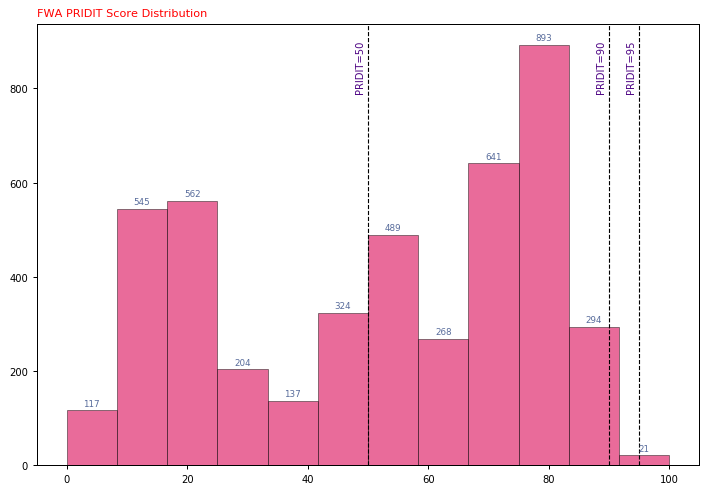

In [24]:
"""
Visualize distribution of PRIDIT scores. Exhibit is a histogram
with binwidth determined using a modified Freedman-Diaconis rule.
"""
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt


def add_value_labels(ax, spacing=3, annotate_font=6, rotation=0, color="#000000"):
    """
    Insert histogram bin frequency counts above each rectangle in histogram.
    """
    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        label = "{0:,.0f}".format(y_value)
        ax.annotate(
            label, (x_value, y_value), xytext=(0, spacing), textcoords="offset points", 
            ha="center", va="bottom", fontsize=annotate_font, rotation=rotation,
            color=color
            )

HISTCOLOR = "#E02C70"
HISTALPHA = .70
yvals     = np.sort(dfpridit["score"].values)
binwidth  = stats.iqr(yvals, rng=(25, 75), scale="raw", nan_policy="omit") / 6
nbrbins   = int(np.ceil((yvals.max() - yvals.min()) / binwidth))
titlestr  = "FWA PRIDIT Score Distribution"
imgpath1  = os.path.join(os.environ["TEMP"], str(uuid.uuid4()) + ".png")

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(9.5, 6.5), dpi=90) 

ax1.hist(yvals, nbrbins, density=False, alpha=HISTALPHA, color=HISTCOLOR, 
        edgecolor="black", linewidth=.50)

yloc0 = max(rect.get_height() for rect in ax1.patches) * .885

xloc0, xloc1, xloc2 = 48, 88, 93

ax1.axvline(
    50, color="#000000", linestyle="--", linewidth=.9
    )
ax1.axvline(
    90, color="#000000", linestyle="--", linewidth=.9
    )
ax1.axvline(
    95, color="#000000", linestyle="--", linewidth=.9
    )
ax1.annotate(
    "PRIDIT=50", (xloc0, yloc0), xytext=(3.5, 0), textcoords="offset points", 
    ha="center", va="bottom", fontsize=8, rotation=90, color="#4b0082"
    )
ax1.annotate(
    "PRIDIT=90", (xloc1, yloc0), xytext=(3.5, 0), textcoords="offset points", 
    ha="center", va="bottom", fontsize=8, rotation=90, color="#4b0082"
    )
ax1.annotate(
    "PRIDIT=95", (xloc2, yloc0), xytext=(3.5, 0), textcoords="offset points", 
    ha="center", va="bottom", fontsize=8, rotation=90, color="#4b0082"
    )

add_value_labels(ax=ax1, spacing=2, annotate_font=7, color="#576b9b")
ax1.set_title(titlestr, color="red", loc="left", fontsize=9)
ax1.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.tick_params(axis="x", which="major", labelsize=8)
ax1.tick_params(axis="x", which="minor", labelsize=8)
ax1.tick_params(axis="y", which="major", labelsize=8)
ax1.tick_params(axis="y", which="minor", labelsize=8)
ax1.grid(False)
plt.savefig(imgpath1)
plt.show()


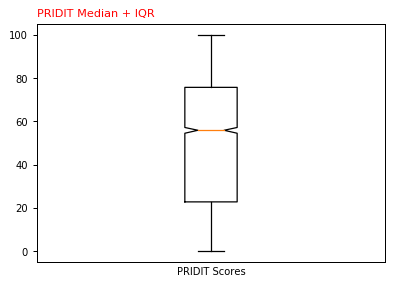

In [25]:
"""
This exhibit is a box-and-whisker plot, which communicates the median 
and inter-quartile range of PRIDIT scores, and provides some sense of 
the skewness of the distribution. 
"""
fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(5, 3.5), dpi=90) 
imgpath2 = os.path.join(os.environ["TEMP"], str(uuid.uuid4()) + ".png")
ax2.boxplot(yvals, notch=True, bootstrap=1000, showfliers=True)
ax2.set_title("PRIDIT Median + IQR", color="red", loc="left", fontsize=9)
ax2.set_xticks([])
ax2.set_xlabel("PRIDIT Scores", fontsize=8)
ax2.tick_params(axis="y", which="major", labelsize=8)
ax2.tick_params(axis="y", which="minor", labelsize=8)
ax2.grid(False)
plt.savefig(imgpath2)
plt.show()


In [26]:
"""
Export PRIDIT score detail, priority claims and PRIDIT transformation 
summary output.
"""
from sklearn.decomposition import PCA

# Use sklearn in order to bind reference to explaiend variance ratio.
pca = PCA(n_components=Z.shape[1])
XX = pca.fit_transform(Z)
dfvratio = pd.DataFrame(pca.explained_variance_ratio_, columns=["explained_variance_ratio"])
dfevecs = pd.DataFrame(e_vectors_)
dfevals = pd.DataFrame(e_values_, columns=["EIGENVALUES"])
dfscore = dfpridit[keycols + ["score"]]
dfthresh = dfthresh.sort_values("ub", ascending=False)[["RANGE", "N"]].reset_index(drop=True)
dfreview = dfpridit.sort_values("score", ascending=False).reset_index(drop=True)
dfsumm = dfsumm.reset_index(drop=False).rename({"index":"measure"}, axis=1)

if REVIEW_THRESHOLD.is_integer():
    # Keep REVIEW_THRESHOLD records with highest PRIDIT scores.
    nbrrecs = REVIEW_THRESHOLD
elif REVIEW_THRESHOLD>=0 and REVIEW_THRESHOLD<1:
    # Retrain REVIEW_THRESHOLD proportion of records with highest PRIDIT score. 
    nbrrecs = int(dfpridit.shape[0] * REVIEW_THRESHOLD + 1)
else:
    raise ValueError("REVIEW_THRESHOLD must be numeric and greater than 0.")
    
dfreview = dfreview.loc[0:nbrrecs,:]
    
dexport = [
    {"df":dfevals,  "sheetname":"Eigenvalues",         "header":True,},
    {"df":dfevecs,  "sheetname":"Eigenvectors",        "header":True,},
    {"df":dfcorr,   "sheetname":"Correlation",         "header":True,},
    {"df":dfload,   "sheetname":"PC1_Loading",         "header":True,},
    {"df":dfscore,  "sheetname":"PRIDIT_Scores",       "header":True,},
    {"df":dfsumm,   "sheetname":"PRIDIT_Summary",      "header":False,},
    {"df":dfthresh, "sheetname":"Scores_by_Threshold", "header":True,},
    {"df":dfvratio, "sheetname":"Variance_Ratio",      "header":True,},
    {"df":dfreview, "sheetname":"Priority_Claims",     "header":True,},
    ]

xlsx_path = os.path.join(EXPORT_PATH, "FWA_PRIDIT_Summary_{}.xlsx".format(DATESTAMP))
writer = pd.ExcelWriter(xlsx_path, engine="xlsxwriter")

try:
    for d_ in dexport:
        try:
            print("Exporting {}".format(d_["sheetname"]))
            d_["df"].to_excel(
                writer, sheet_name=d_["sheetname"], index=False, header=d_["header"]
                )
        except:
            print("Error exporting {}".format(d_["sheetname"]))
            
    # Embed imgpath1 and imgpath2 in workbook.
    pd.DataFrame().to_excel(
        writer, sheet_name="PRIDIT_Histogram", startrow=1, header=False, index=False
        )
    worksheet = writer.sheets["PRIDIT_Histogram"]
    worksheet.insert_image("A1", imgpath1)
    
    pd.DataFrame().to_excel(
        writer, sheet_name="PRIDIT_Boxplot", startrow=1, header=False, index=False
        )
    worksheet = writer.sheets["PRIDIT_Boxplot"]
    worksheet.insert_image("A1", imgpath2)
    
finally:
    writer.save()


Exporting Eigenvalues
Exporting Eigenvectors
Exporting Correlation
Exporting PC1_Loading
Exporting PRIDIT_Scores
Exporting PRIDIT_Summary
Exporting Scores_by_Threshold
Exporting Variance_Ratio
Exporting Priority_Claims
